# Sampling from a GP

## Preliminary steps

### Loading necessary packages

In [1]:
using Plots
using AugmentedGaussianProcesses
using Distributions
using LinearAlgebra

### Generating some random data

In [2]:
kernel = SqExponentialKernel()
x = range(0, 10; length=50)
K = kernelmatrix(kernel, x)
f = rand(MvNormal(K + 1e-8I)) # Sample a random GP
y = rand.(Bernoulli.(AGP.logistic.(f)))
y_sign = Int.(sign.(y .- 0.5))

50-element Vector{Int64}:
  1
  1
  1
  1
  1
  1
  1
 -1
  1
  1
  ⋮
  1
 -1
  1
  1
 -1
 -1
 -1
 -1
 -1

### We create a function to visualize the data

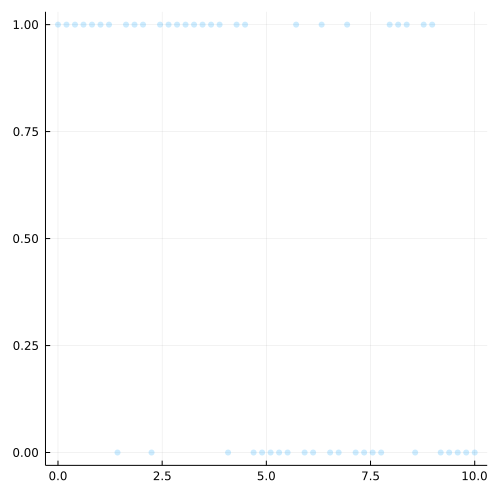

In [3]:
function plot_data(x, y; size=(300, 500))
    return Plots.scatter(x, y; alpha=0.2, markerstrokewidth=0.0, lab="", size=size)
end
plot_data(x, y; size=(500, 500))

### Run the variational gaussian process approximation

In [4]:
@info "Running full model"
mfull = VGP(x, y_sign, kernel, LogisticLikelihood(), AnalyticVI(); optimiser=false)
@time train!(mfull, 5)

[ Info: Running full model
  1.018410 seconds (1.82 M allocations: 103.773 MiB, 99.53% compilation time)


(Variational Gaussian Process with a BernoulliLikelihood{GPLikelihoods.LogisticLink}(GPLikelihoods.LogisticLink(LogExpFunctions.logistic)) infered by Analytic Variational Inference , (local_vars = (c = [1.3669972276985045, 1.4164558745949143, 1.4407289722720307, 1.4365248305062428, 1.406237780726544, 1.3575859352386905, 1.3019796440993938, 1.2519312633160147, 1.2188093465229914, 1.209831224424989  …  0.6005947888746833, 0.602021775177851, 0.600151911308392, 0.6080617291825443, 0.6497801648027397, 0.7373274877122347, 0.8566747727295658, 0.9801986893573924, 1.0830848131775186, 1.1506341242683507], θ = [0.21718740263373518, 0.21517239859031492, 0.21417457240527937, 0.2143477913233516, 0.2155907548589202, 0.21756786155060978, 0.21979450037668996, 0.22176456582747123, 0.22304878891415142, 0.22339403987472156  …  0.24274664958013972, 0.24271334728698024, 0.24275697140148264, 0.24257163794697445, 0.24156003846635452, 0.23925755936649198, 0.2357551052593545, 0.2317363217680756, 0.2281236968409

### We can also create a sampling based model

In [5]:
@info "Sampling from model"
mmcmc = MCGP(x, y, kernel, LogisticLikelihood(), GibbsSampling(); optimiser=false)
m = mmcmc
@time samples = sample(mmcmc, 1000)

[ Info: Sampling from model
Sampling with Gibbs Sampler   0%|                       |  ETA: N/A
Sampling with Gibbs Sampler   0%|▏                      |  ETA: 0:06:08
Sampling with Gibbs Sampler   1%|▎                      |  ETA: 0:03:07
Sampling with Gibbs Sampler   1%|▍                      |  ETA: 0:02:04
Sampling with Gibbs Sampler   2%|▍                      |  ETA: 0:01:33
Sampling with Gibbs Sampler   2%|▌                      |  ETA: 0:01:14
Sampling with Gibbs Sampler   3%|▋                      |  ETA: 0:01:01
Sampling with Gibbs Sampler   3%|▊                      |  ETA: 0:00:53
Sampling with Gibbs Sampler   4%|▉                      |  ETA: 0:00:46
Sampling with Gibbs Sampler   4%|█                      |  ETA: 0:00:41
Sampling with Gibbs Sampler   5%|█                      |  ETA: 0:00:36
Sampling with Gibbs Sampler   5%|█▏                     |  ETA: 0:00:33
Sampling with Gibbs Sampler   5%|█▎                     |  ETA: 0:00:30
Sampling with Gibbs Sampler   6%|█▍     

1000-element Vector{Vector{Vector{Float64}}}:
 [[2.4363761790050935, 2.423595038786922, 2.3466054346354133, 2.1327023113446923, 1.8872742654235015, 1.561656805058929, 1.22877560662388, 0.9084286787869047, 0.6775154188778321, 0.59407207126232  …  -0.527042325309423, -0.11698894456703292, 0.22342372025464732, 0.5170488306649863, 0.7004394544627692, 0.7630096444673757, 0.7547873837295043, 0.6499205453520723, 0.4747222684151837, 0.2704914922114241]]
 [[0.6395618019617035, 0.4393441294933431, 0.2167249046641324, 0.03765859944345307, -0.09319023926387415, -0.17100630108678705, -0.1634365685709518, -0.08504470599281722, 0.05445322431662836, 0.23654259321325016  …  0.45068076755789244, 0.46580137801790783, 0.39679774001610624, 0.27261118788864713, 0.06774666862711329, -0.1363223566722873, -0.35030985365032175, -0.5239276511360582, -0.5807979845204359, -0.5774690734992008]]
 [[0.8208286323803664, 0.8146368387733893, 0.7817126337694508, 0.7812090851509941, 0.7483167800793548, 0.6950752574725554,

### We can now visualize the results of both models

### We first plot the latent function f (truth, the VI estimate, the samples)

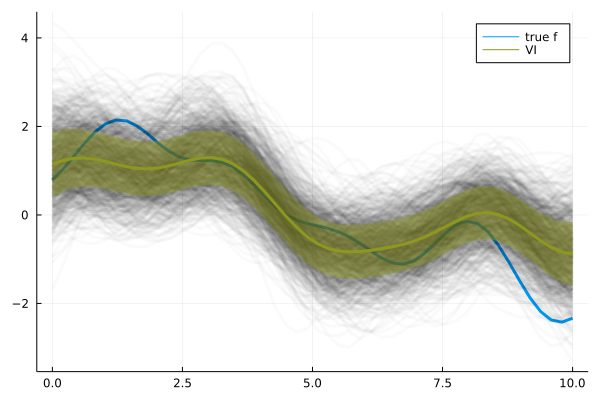

In [6]:
p1 = plot(x, f; label="true f")
plot!(x, samples; label="", color=:black, alpha=0.02, lab="")
plot!(x, mean(mfull[1]); ribbon=sqrt.(var(mfull[1])), label="VI")

### And we can also plot the predictions vs the data

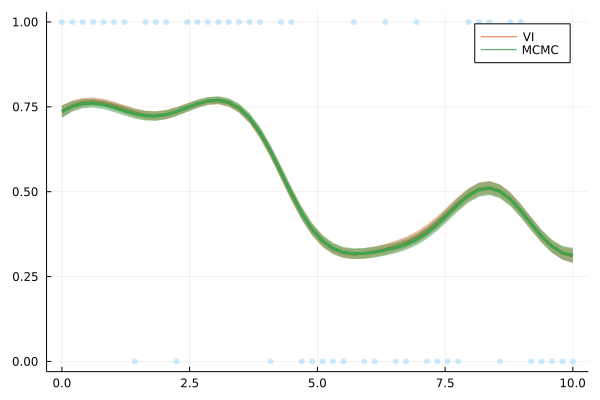

In [7]:
p2 = plot_data(x, y; size=(600, 400))
μ_vi, σ_vi = proba_y(mfull, x)
plot!(x, μ_vi; ribbon=σ_vi, label="VI")
μ_mcmc, σ_mcmc = proba_y(mmcmc, x)
plot!(x, μ_mcmc; ribbon=σ_mcmc, label="MCMC")

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*